In [52]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
import utils
import os

fpaths = [] #file paths
for f in os.listdir('audio'):
    for w in os.listdir('audio/' + f):
        ;#print(w)#file names
    

In [54]:
fpaths = []
labels= []
spoken = []
for f in os.listdir('audio'):
    for w in os.listdir('audio/'+f):
        fpaths.append('audio/'+f+'/'+w)
        labels.append(f) #all labels
        if f not in spoken:
            spoken.append(f)
print('Words: ',spoken);
        

('Words: ', ['lime', 'pineapple', 'orange', 'peach', 'banana', 'kiwi', 'apple'])


7 different words are spoken, each 15 times. Everything is done by only one user.

In [55]:
#Files can be heard in Linux using the following commands from the command line
#cat kiwi07.wav | aplay -f S16_LE -t wav -r 8000
#Files are signed 16 bit raw = y axis sampling, sample rate 8000

numCols = 4*8000  #each is 4s long at frequency = 8000, so there is 32000 recordings - let say, at most
from scipy.io import wavfile

data = np.zeros((len(fpaths),numCols))
maxsize = -1
for n,file in enumerate(fpaths):#paths are relative to this notebook
    _, d = wavfile.read(file)  #Return the sample rate (in samples/sec) and data from a WAV file
    #print(d.shape)
    data[n, :d.shape[0]] = d
    if d.shape[0] > maxsize:
        maxsize = d.shape[0]
data = data[:, :maxsize] #resize matrix


#Let extract the files into the matrix
#each file will have the labes=0-7


#let address labels - real class of each recording
print('Number of files:', data.shape[0])
all_labels = np.zeros(data.shape[0])

for n, l in enumerate(set(labels)): #labels are set
    all_labels[np.array([i for i, _ in enumerate(labels) if _ == l])] = n
    
print('Labels and label indices', all_labels)

('Number of files:', 105)
('Labels and label indices', array([ 6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]))


Now, the features/attributes should be extracted.

The features that describe time and frequency should be extracted.

In this example, simple frequency peak detection was used, rather than the bevy of expert features typically used in a modern speech recognition pipeline (MFCCs, or more recently, a pretrained multilayer neural network). This has a direct effect on performance, but allows for a holistic implementation that fits in a single post :)


In [56]:
import scipy

#x-is the input signal
#fftsize- number of the instances over which tto get mean amplitude (one spectrogram value)
#overlap_pct- is precentage of the spectrogram range that will overlap
#             [10:74] is one spectrogram value range, [42:106] 
#              is another spectogram range. Dure to the overlap_pct = .5
def stft(x, fftsize=64, overlap_pct=.5): #short fuier transform.  
    #Modified from http://stackoverflow.com/questions/2459295/stft-and-istft-in-python
    hop = int(fftsize * (1 - overlap_pct)) #the number of the instances to be hopped from the beginning of the laprevious
                                                #spectogram range to create the next one.
    w = scipy.hanning(fftsize + 1)[:-1]    
    raw = np.array([np.fft.rfft(w * x[i:i + fftsize]) for i in range(0, len(x) - fftsize, hop)])
    return raw[:, :(fftsize // 2)]

(216, 32)


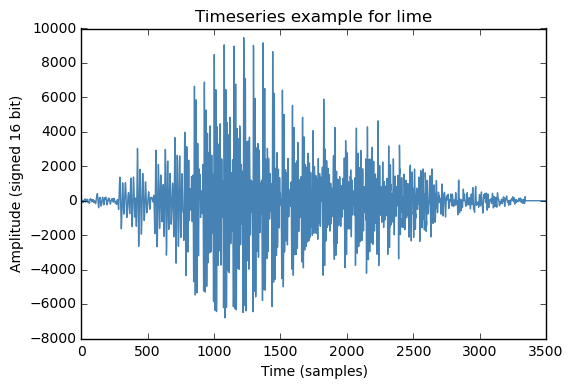

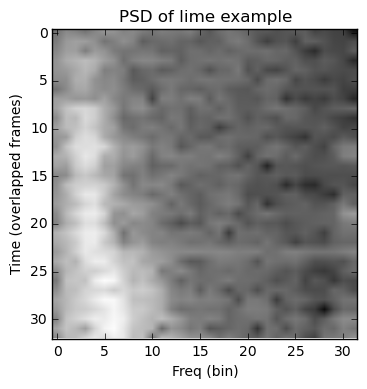

In [57]:
import matplotlib.pyplot as plt
plt.plot(data[0, :], color='steelblue')
plt.title('Timeseries example for %s'%labels[0])
plt.xlim(0, 3500)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (signed 16 bit)')
plt.figure()

# + 1 to avoid log of 0
log_freq = 20 * np.log(np.abs(stft(data[0, :])) + 1)
print(log_freq.shape)
plt.imshow(log_freq, cmap='gray', interpolation=None)
plt.xlabel('Freq (bin)')
plt.ylabel('Time (overlapped frames)')
plt.ylim(log_freq.shape[1])
plt.title('PSD of %s example'%labels[0])

In [58]:
from numpy.lib.stride_tricks import as_strided

#Peak detection using the technique described here: http://kkjkok.blogspot.com/2013/12/dsp-snippets_9.html 
def peakfind(x, n_peaks, l_size=3, r_size=3, c_size=3, f=np.mean):
    win_size = l_size + r_size + c_size
    #create a strides from sequence x. shape = (no_strides, len_strides)
    #http://stackoverflow.com/questions/4936620/using-strides-for-an-efficient-moving-average-filter
    shape = x.shape[:-1] + (x.shape[-1] - win_size + 1, win_size)
    
    strides = x.strides + (x.strides[-1],)
    xs = as_strided(x, shape=shape, strides=strides)
    def is_peak(x):
        centered = (np.argmax(x) == l_size + int(c_size/2))
        l = x[:l_size]
        c = x[l_size:l_size + c_size]
        r = x[-r_size:]
        passes = np.max(c) > np.max([f(l), f(r)])
        if centered and passes:
            return np.max(c)
        else:
            return -1
    #print xs
    r = np.apply_along_axis(is_peak, 1, xs) #along column. Along each defined stride.
    #print r
    top = np.argsort(r, None)[::-1]
    heights = r[top[:n_peaks]]
    #Add l_size and half - 1 of center size to get to actual peak location
    top[top > -1] = top[top > -1] + l_size + int(c_size / 2.)
    return heights, top[:n_peaks]

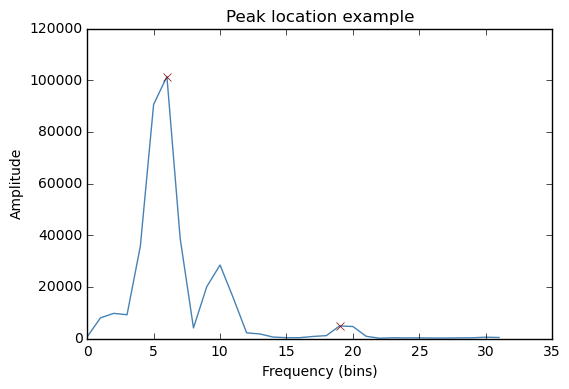

In [59]:
plot_data = np.abs(stft(data[20, :]))
#for FFT window 15
plot_data = plot_data[15, :]

values, locs = peakfind(plot_data, n_peaks=6)
fp = locs[values > -1]
fv = values[values > -1]
plt.plot(plot_data, color='steelblue')
plt.plot(fp, fv, 'x', color='darkred')
plt.title('Peak location example')
plt.xlabel('Frequency (bins)')
plt.ylabel('Amplitude')


In [60]:
#Finding 6 highest peaks per FFT frame.
all_obs = []
for i in range(data.shape[0]):
    d = np.abs(stft(data[i, :]))
    n_dim = 6
    obs = np.zeros((n_dim, d.shape[0]))
    for r in range(d.shape[0]):
        _, t = peakfind(d[r, :], n_peaks=n_dim)
        obs[:, r] = t.copy()
    if i % 10 == 0:
        print("Processed obs %s" % i)
    all_obs.append(obs)
    
all_obs = np.atleast_3d(all_obs)

Processed obs 0
Processed obs 10
Processed obs 20
Processed obs 30
Processed obs 40
Processed obs 50
Processed obs 60
Processed obs 70
Processed obs 80
Processed obs 90
Processed obs 100


In [61]:
print(sum(all_obs[1][5])/216)
all_obs[1]

7.43518518519


array([[ 16.,  15.,  16., ...,  27.,  27.,  27.],
       [ 27.,  20.,  24., ...,  26.,  26.,  26.],
       [ 14.,  14.,  27., ...,   5.,   5.,   5.],
       [  5.,   5.,  14., ...,   6.,   6.,   6.],
       [  6.,   6.,   5., ...,   7.,   7.,   7.],
       [  7.,   7.,   6., ...,   8.,   8.,   8.]])

In [62]:
import scipy.stats as st
import numpy as np

class gmmhmm:
    #This class converted with modifications from https://code.google.com/p/hmm-speech-recognition/source/browse/Word.m
    def __init__(self, n_states):
        self.n_states = n_states
        #PSEUDO RANDOM GENERATOR WITH seed equal to 0.
        self.random_state = np.random.RandomState(0)
        
        #Normalize random initial state
                    #Random values in a given shape. self.n_states* 1
            #set initial states distribution as well as initiaj Bj distribution
            #of values due to the certain state.
        self.prior = self._normalize(self.random_state.rand(self.n_states, 1))
        self.A = self._stochasticize(self.random_state.rand(self.n_states, self.n_states))
        
        self.mu = None
        self.covs = None
        self.n_dims = None
           
    def _forward(self, B):
        log_likelihood = 0.
        T = B.shape[1]
        alpha = np.zeros(B.shape)
        for t in range(T):
            if t == 0:
                alpha[:, t] = B[:, t] * self.prior.ravel()
            else:
                alpha[:, t] = B[:, t] * np.dot(self.A.T, alpha[:, t - 1])
         
            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood = log_likelihood + np.log(alpha_sum)
        return log_likelihood, alpha
    
    def _backward(self, B):
        T = B.shape[1]
        beta = np.zeros(B.shape);
           
        beta[:, -1] = np.ones(B.shape[0])
            
        for t in range(T - 1)[::-1]:
            beta[:, t] = np.dot(self.A, (B[:, t + 1] * beta[:, t + 1]))
            beta[:, t] /= np.sum(beta[:, t])
        return beta
    #indicates that you shouldnt do this.
    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.n_states, obs.shape[1]))
        for s in range(self.n_states):
            #Needs scipy 0.14
            np.random.seed(self.random_state.randint(1))
            B[s, :] = st.multivariate_normal.pdf(
                obs.T, mean=self.mu[:, s].T, cov=self.covs[:, :, s].T)
            #This function can (and will!) return values >> 1
            #See the discussion here for the equivalent matlab function
            #https://groups.google.com/forum/#!topic/comp.soft-sys.matlab/YksWK0T74Ak
            #Key line: "Probabilities have to be less than 1,
            #Densities can be anything, even infinite (at individual points)."
            #This is evaluating the density at individual points...
        return B
    
    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)
    
    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)
    
    def _em_init(self, obs):
        #Using this _em_init function allows for less required constructor args.
        if self.n_dims is None:
            self.n_dims = obs.shape[0]
        if self.mu is None:
            subset = self.random_state.choice(np.arange(self.n_dims), size=self.n_states, replace=False)
           # print(self.n_dims)
            self.mu = obs[:,subset]
        if self.covs is None:
            self.covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
            self.covs += np.diag(np.diag(np.cov(obs)))[:, :, None]
        return self
    
    def _em_step(self, obs): 
        obs = np.atleast_2d(obs)
        B = self._state_likelihood(obs)
        T = obs.shape[1]
        
        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)
        
        xi_sum = np.zeros((self.n_states, self.n_states))
        gamma = np.zeros((self.n_states, T))
        
        for t in range(T - 1):
            partial_sum = self.A * np.dot(alpha[:, t], (beta[:, t] * B[:, t + 1]).T)
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)
              
        partial_g = alpha[:, -1] * beta[:, -1]
        gamma[:, -1] = self._normalize(partial_g)
        
        expected_prior = gamma[:, 0]
        expected_A = self._stochasticize(xi_sum)
        
        expected_mu = np.zeros((self.n_dims, self.n_states))
        expected_covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
        
        gamma_state_sum = np.sum(gamma, axis=1)
        #Set zeros to 1 before dividing
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)
        
        for s in range(self.n_states):
            gamma_obs = obs * gamma[s, :]
            expected_mu[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]
            partial_covs = np.dot(gamma_obs, obs.T) / gamma_state_sum[s] - np.dot(expected_mu[:, s], expected_mu[:, s].T)
            #Symmetrize
            partial_covs = np.triu(partial_covs) + np.triu(partial_covs).T - np.diag(partial_covs)
        
        #Ensure positive semidefinite by adding diagonal loading
        expected_covs += .01 * np.eye(self.n_dims)[:, :, None]
        
        self.prior = expected_prior
        self.mu = expected_mu
        self.covs = expected_covs
        self.A = expected_A
        return log_likelihood
    
    def fit(self, obs, n_iter=15):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            for i in range(n_iter):
                self._em_init(obs)
                log_likelihood = self._em_step(obs)
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            for n in range(count):
                for i in range(n_iter):
                    self._em_init(obs[n, :, :])
                    log_likelihood = self._em_step(obs[n, :, :])
        return self
    
    def transform(self, obs):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            B = self._state_likelihood(obs)
            log_likelihood, _ = self._forward(B)
            return log_likelihood
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            out = np.zeros((count,))
            for n in range(count):
                B = self._state_likelihood(obs[n, :, :])
                log_likelihood, _ = self._forward(B)
                out[n] = log_likelihood
            return out

In [63]:
from sklearn.cross_validation import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(all_labels, test_size=0.1, random_state=0)

for n,i in enumerate(all_obs):
    all_obs[n] /= all_obs[n].sum(axis=0)

for train_index, test_index in sss:
    X_train, X_test = all_obs[train_index, ...], all_obs[test_index, ...]
    y_train, y_test = all_labels[train_index], all_labels[test_index]
print('Size of training matrix:', X_train.shape)
print('Size of testing matrix:', X_test.shape)

('Size of training matrix:', (94, 6, 216))
('Size of testing matrix:', (11, 6, 216))


In [64]:
ys = set(all_labels) #labels
ms = [gmmhmm(6) for y in ys] ## init gmmhmm
_ = [m.fit(X_train[y_train == y, :, :]) for m, y in zip(ms, ys)]
ps = [m.transform(X_test) for m in ms]
res = np.vstack(ps)
predicted_labels = np.argmax(res, axis=0)
missed = (predicted_labels != y_test)
print('Test accuracy: %.2f percent' % (100 * (1 - np.mean(missed))))

Test accuracy: 81.82 percent


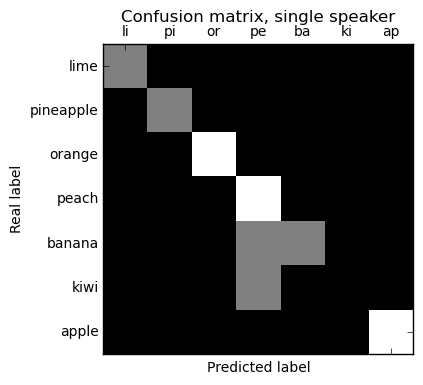

In [65]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.matshow(cm, cmap='gray')
ax = plt.gca()
_ = ax.set_xticklabels([" "] + [l[:2] for l in spoken])
_ = ax.set_yticklabels([" "] + spoken)
plt.title('Confusion matrix, single speaker')
plt.ylabel('Real label')
plt.xlabel('Predicted label')

In [66]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score

#one agains the rest
#scikit-learn.org/stable/modules/svm.html#multi-class-classification
clf = svm.SVC(decision_function_shape='ovr')
all_svm = np.zeros((105,6*216))
for i in xrange(0,len(all_obs)):
    temp = all_obs[i].reshape(1,216*6)
    all_svm[i] = temp
print(all_labels)
sssComp = StratifiedShuffleSplit(all_labels, test_size=0.4, train_size=0.6, random_state=0)

for train_index, test_index in sssComp:
    X_model, X_acc = all_svm[train_index, ...], all_svm[test_index, ...]
    y_model, y_acc = all_labels[train_index], all_labels[test_index]
print(X_model.shape)
print(y_acc.shape)
print(X_acc.shape)

for train_index, test_index in sssComp:
    X_model1, X_acc1 = all_obs[train_index, ...], all_svm[test_index, ...]
    y_model1, y_acc1 = all_labels[train_index], all_labels[test_index]

[ 6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
(63, 1296)
(42,)
(42, 1296)


Automatically created module for IPython interactive environment
training score : 0.210 (multinomial)
training score : 0.200 (ovr)


/usr/local/lib/python2.7/dist-packages/ipykernel-4.5.1-py2.7.egg/ipykernel/__main__.py:58: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


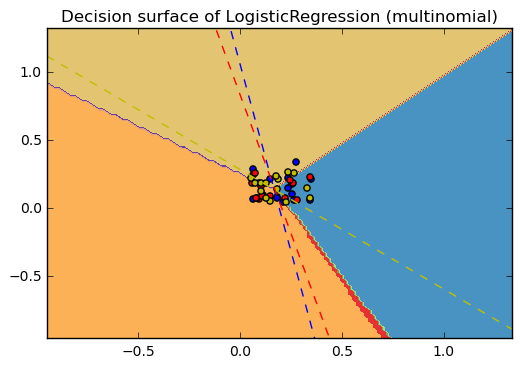

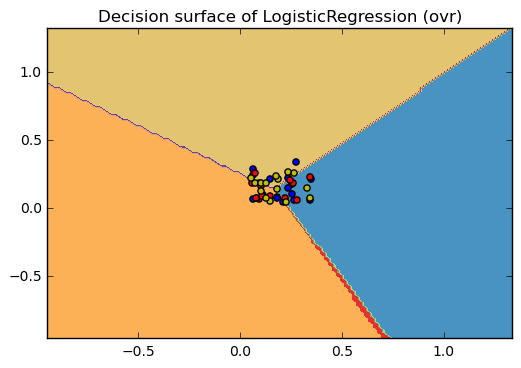

In [67]:
print(__doc__)
# Authors: Tom Dupre la Tour <tom.dupre-la-tour@m4x.org>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
#X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
#X = np.dot(X, transformation)
X1 = np.zeros((105,2)) 
for i in xrange(0,105):
    X1[i] = all_svm[i][0:2]
y1 = all_labels

for multi_class in ('multinomial', 'ovr'):
    clf = LogisticRegression(solver='sag', max_iter=100, random_state=42,
                             multi_class=multi_class).fit(X1, y1)

    # print the training scores
    print("training score : %.3f (%s)" % (clf.score(X1, y1), multi_class))

    # create a mesh to plot in
    h = .02  # step size in the mesh
    x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
    y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title("Decision surface of LogisticRegression (%s)" % multi_class)
    plt.axis('tight')

    # Plot also the training points
    colors = "bry"
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y1 == i)
        plt.scatter(X1[idx, 0], X1[idx, 1], c=color, cmap=plt.cm.Paired)

    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    coef = clf.coef_
    intercept = clf.intercept_

    def plot_hyperplane(c, color):
        def line(x0):
            return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
        plt.plot([xmin, xmax], [line(xmin), line(xmax)],
                 ls="--", color=color)

    for i, color in zip(clf.classes_, colors):
        plot_hyperplane(i, color)

plt.show()

Automatically created module for IPython interactive environment
explained variance ratio (first two components): [ 0.62058596  0.37941404]


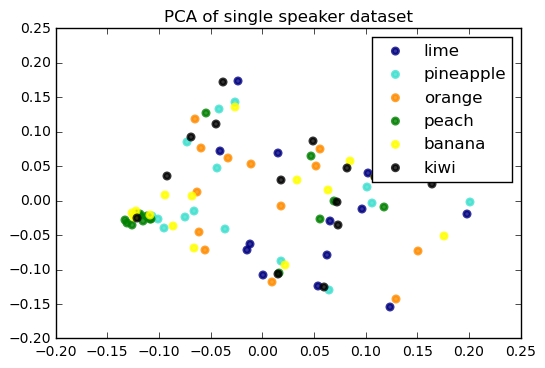

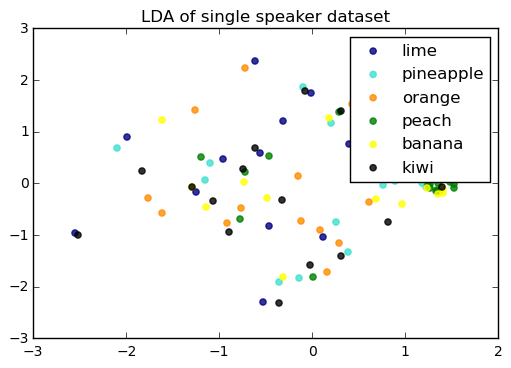

In [68]:
print(__doc__)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = X1
y = y1
target_names = spoken

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange', 'green', 'yellow', 'black', 'red']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2, 4, 5, 6], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of single speaker dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2, 4, 5, 6], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of single speaker dataset')

plt.show()

In [69]:
# As we have only 15 samples for each class, 
# there is no point into putting the big number for n_neighbors.
from sklearn import neighbors

n_neighbors = [1,2,3,4,5,6]
for weights in ['uniform', 'distance']:
    for neighbor in n_neighbors:
        clf = neighbors.KNeighborsClassifier(neighbor, weights=weights)
        scores = cross_val_score(clf, X_model, y_model, cv=6)
        print("KNN with %s neighbors and weights = %s" % (neighbor,weights))
        m = np.mean(scores)
        print("Cross-validation estimation: %s" % m)
#DT
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
scores = cross_val_score(clf, X_model, y_model, cv=6)
print("Decision tree estimator.")
print("Cross-validation estimation: %s" % np.mean(scores))

KNN with 1 neighbors and weights = uniform
Cross-validation estimation: 0.869047619048
KNN with 2 neighbors and weights = uniform
Cross-validation estimation: 0.880952380952
KNN with 3 neighbors and weights = uniform
Cross-validation estimation: 0.821428571429
KNN with 4 neighbors and weights = uniform
Cross-validation estimation: 0.809523809524
KNN with 5 neighbors and weights = uniform
Cross-validation estimation: 0.797619047619
KNN with 6 neighbors and weights = uniform
Cross-validation estimation: 0.77380952381
KNN with 1 neighbors and weights = distance
Cross-validation estimation: 0.869047619048
KNN with 2 neighbors and weights = distance
Cross-validation estimation: 0.869047619048
KNN with 3 neighbors and weights = distance
Cross-validation estimation: 0.821428571429
KNN with 4 neighbors and weights = distance
Cross-validation estimation: 0.845238095238
KNN with 5 neighbors and weights = distance
Cross-validation estimation: 0.785714285714
KNN with 6 neighbors and weights = dist

In [77]:
#Class MLPClassifier implements a multi-layer perceptron (MLP) algorithm that trains using Backpropagation.
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

# different learning rate schedules and momentum parameters
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.2},
          
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate",
          "inv-scaling learning-rate", "inv-scaling with momentum",
          "inv-scaling with Nesterov's momentum", "adam"]

plot_args = [{'c': 'red', 'linestyle': '-'},
             {'c': 'red', 'linestyle': '--'},
             {'c': 'green', 'linestyle': '--'},
             {'c': 'blue', 'linestyle': '--'},
             {'c': 'black', 'linestyle': '-'}]

#http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py
max_iter=400
print("ANN models:")
for label, param in zip(labels, params):
    print("training: %s" % label)
    mlp = MLPClassifier(verbose=0, random_state=0,max_iter=max_iter, **param)
    scores = cross_val_score(mlp, X_model, y_model, cv=6)
    print("Cross-validation estimation: %s" % np.mean(scores))

print("GMMHMM: ")
ys = set(all_labels) #labels
ms = [gmmhmm(6) for y in ys] 
scores = np.zeros((6,1));
from sklearn.cross_validation import StratifiedShuffleSplit
for j in xrange(0,6):
    sss = StratifiedShuffleSplit(y_model1, test_size=0.1, random_state=j)
    for train_index, test_index in sss:
        X_train1, X_test1 = X_model1[train_index, ...], X_model1[test_index, ...]
        y_train1, y_test1 = y_model1[train_index], y_model1[test_index]
    ms = [gmmhmm(6) for y in ys]
    _ = [m.fit(X_train1[y_train1 == y, :, :]) for m, y in zip(ms, ys)]
    ps = [m.transform(X_test1) for m in ms]
    res = np.vstack(ps)
    predicted_labels = np.argmax(res, axis=0)
    missed = (predicted_labels != y_test1)
    scores[j] = (100 * (1 - np.mean(missed)))
print('Test accuracy: %.2f percent' % (100 * (1 - np.mean(missed)))) 

ANN models:
training: constant learning-rate
Cross-validation estimation: 0.654761904762
training: inv-scaling learning-rate
Cross-validation estimation: 0.321428571429
training: inv-scaling with momentum
Cross-validation estimation: 0.988095238095
training: inv-scaling with Nesterov's momentum
Cross-validation estimation: 0.988095238095
training: adam
Cross-validation estimation: 0.22619047619
GMMHMM: 
Test accuracy: 71.43 percent


In [74]:
#Estimate on the initial data, becuse, other way set is too small.
#KNN
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    all_svm, all_labels, test_size=0.3, random_state=0)
for weights in ['uniform', 'distance']:
    for neighbor in n_neighbors:
        clf = neighbors.KNeighborsClassifier(neighbor, weights=weights)
        clf.fit(X_train, y_train)
        clf.score(X_test,y_test)
        print("KNN with %s neighbors and weights = %s" % (neighbor,weights))
        m = clf.score(X_test,y_test)
        print("Accuracy: %s" % m)
        
#DT
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)
m = clf.score(X_test,y_test)
print("Decision tree estimator.")
print("Accuracy: %s" % m)

KNN with 1 neighbors and weights = uniform
Accuracy: 0.9375
KNN with 2 neighbors and weights = uniform
Accuracy: 0.90625
KNN with 3 neighbors and weights = uniform
Accuracy: 0.9375
KNN with 4 neighbors and weights = uniform
Accuracy: 0.90625
KNN with 5 neighbors and weights = uniform
Accuracy: 0.84375
KNN with 6 neighbors and weights = uniform
Accuracy: 0.84375
KNN with 1 neighbors and weights = distance
Accuracy: 0.9375
KNN with 2 neighbors and weights = distance
Accuracy: 0.9375
KNN with 3 neighbors and weights = distance
Accuracy: 0.96875
KNN with 4 neighbors and weights = distance
Accuracy: 0.96875
KNN with 5 neighbors and weights = distance
Accuracy: 0.90625
KNN with 6 neighbors and weights = distance
Accuracy: 0.9375
Decision tree estimator.
Accuracy: 0.75


In [73]:

X_train, X_test, y_train, y_test = train_test_split(
    X_acc, y_acc, test_size=0.3, random_state=0)
print("ANN models:")
for label, param in zip(labels, params):
    print("training: %s" % label)
    mlp = MLPClassifier(verbose=0, random_state=0,max_iter=max_iter, **param)
    mlp.fit(X_train,y_train)
    m = mlp.score(X_test,y_test)
    print("Accuracy: %s" % m)

print("GMMHMM: ")
ys = set(all_labels) #labels

sss = StratifiedShuffleSplit(y_acc1, test_size=0.3, random_state=0)
for train_index, test_index in sss:
    X_train, X_test = X_acc1[train_index, ...], X_acc1[test_index, ...]
    y_train, y_test = y_acc1[train_index], y_acc1[test_index]
ms = [gmmhmm(6) for y in ys]
_ = [m.fit(X_train[y_train == y, :, :]) for m, y in zip(ms, ys)]
ps = [m.transform(X_test) for m in ms]
res = np.vstack(ps)
predicted_labels = np.argmax(res, axis=0)
missed = (predicted_labels != y_test)
print('Test accuracy: %.2f percent' % (100 * (1 - np.mean(missed)))) 

ANN models:
training: constant learning-rate
Accuracy: 0.230769230769
training: inv-scaling learning-rate
Accuracy: 0.230769230769
training: inv-scaling with momentum
Accuracy: 0.923076923077
training: inv-scaling with Nesterov's momentum
Accuracy: 0.923076923077
training: adam
Accuracy: 0.461538461538
GMMHMM: 
Test accuracy: 81.25 percent


SyntaxError: non-keyword arg after keyword arg (<ipython-input-146-2d9eaf492066>, line 3)